# Tutkitaan ja esikäsitellään total_installed_price

Tämän työvaiheen alussa käytetään esikäsittelemätöntä dataa. Työvaiheeseen sisältyy datan tutkimista, joten monipuolisen tutkimisen helpottamiseksi luodaan koko datasta yksi DataFrame, josta voidaan ottaa kopio aina uuden koodilohkon alussa. Lopussa on hahmoteltu esikäsittelymoduuliin tulevaa esikäsittelyä.

Osa kokeellisemmasta tutkimuksesta on karsittu lukukokemuksen parantamiseksi.

## Tehdään lohkoihin pohjalle DataFrame

Tässä lohkossa tehdään myös muutama usein käytetty esikäsittely. Päiväys muutetaan parempaa tietotyyppiin ja määritetään kaksi uutta saraketta.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url ="../data/LBNL_file.csv"
df_all = pd.read_csv(url, low_memory=False, na_values = '-9999')
df_all['installation_date'] = pd.to_datetime(df_all['installation_date'], format='%d-%b-%Y %H:%M:%S') 
df_all['year'] = df_all['installation_date'].dt.year
df_all['price_per_kw'] = df_all['total_installed_price'] / df_all['system_size_DC']
df = df_all.copy()

## Eräs löydös

Jossain vaiheessa kokeilujen avulla havaittiin, että sarakkeen 'new_construction' arvon ollessa `NaN` 'total_installed_price' arvo saattaa olla epäilyttävä. Tälle ei ilmeisesti ole mitään suoraa loogista selitystä, mutta havainnon avulla nähdään realistisempi arvo asennuksen minimihinnalle, vaikka 'new_construction' arvoilla `0` ja `1` otokset jäävätkin huomattavan pieniksi verrattuna `NaN` arvon otokseen.

In [2]:
df = df_all.copy()
df['new_construction'] = df['new_construction'].replace(np.nan, 2)
#df['new_construction'] = df['new_construction'].replace(0, np.nan)
#df['new_construction'] = df['new_construction'].replace(1, np.nan)


df = df[(df['year'] > 2014)]
df.groupby(['new_construction']).agg({'total_installed_price': ['size', 'count', 'min', 'median', 'mean', 'max'], 'price_per_kw': ['min', 'max']})

total_installed_price                             \
                                  size   count      min    median   
new_construction                                                    
0.0                               1981    1981  5977.80  26660.00   
1.0                              36904   36904  3726.00   9691.68   
2.0                             664621  598669     0.01  23552.00   

                                            price_per_kw                 
                          mean          max          min            max  
new_construction                                                         
0.0               33284.108667    823101.40  1327.201183    8197.255575  
1.0               13197.468451   1458758.00   966.670455  385914.814815  
2.0               33085.708996  61507191.42     0.000019  189393.939394

## Toinen löydös

Vähän parempi kuin edellinen löydös. Huomataan myös, että `total_installed_price` tunnusluvut ovat samat, kun `new_construction == 1` tai `data_provider_2 == "California Energy Commission"`.

Tämä on ehkä vähän loogisempi, sillä datan toimittaja tai kerääjä saattaa vaikuttaa siihen, miten dataa on kerätty, kirjattu ja validoitu.

In [3]:
df = df_all.copy()
df['data_provider_2'] = df['data_provider_2'].replace(np.nan, 2)


df = df[(df['year'] > 2014)]
df.groupby(['data_provider_2']).agg({'total_installed_price': ['size', 'count', 'min', 'median', 'mean', 'max'], 'price_per_kw': ['min', 'max']})

total_installed_price                   \
                                                        size   count      min   
data_provider_2                                                                 
2                                                     659323  593371     0.01   
California Energy Commission                           36904   36904  3726.00   
California Public Utilities Commission                  7279    7279  5157.72   

                                                                              \
                                          median           mean          max   
data_provider_2                                                                
2                                       23664.00   31892.897448  20000000.00   
California Energy Commission             9691.68   13197.468451   1458758.00   
California Public Utilities Commission  18582.77  130375.558000  61507191.42   

                                       price_per_kw                 
                                                min            max  
data_provider_2                                                     
2                                          0.000019  189393.939394  
California Energy Commission             966.670455  385914.814815  
California Public Utilities Commission   818.594988  126355.214717

## Tunnuslukuja 'price_per_kW':n rajauksella

Siirrytään tutkimaan asiaa hintatehosuhteen avulla. Jos asennuksen hinta on epämääräisen pieni, silloin todennäköisesti myös hintatehosuhde on pieni. Luku huomioi myös asennetun voimalan tehon, joten samalla löytyvät tehoon nähden liian halvat asennukset. Alla olevasta taulukosta nähdään, että lähempänä pienen asennuksen realistista hintaa olevat asennukset jäävät puolestaan hintatehosuhteeltaan epärealistisen pieniksi. Tästä johtuen lienee tarpeellista tutkia tarkemmin sitä, miten hintatehosuhteen arvot jakautuvat.

In [4]:
df = df_all.copy()
df = df[(df['price_per_kw'] < 80)]
df = df[(df['price_per_kw'] >= 0)]
df = df[(df['year'] > 2014)]
df.groupby(['year']).agg({'installation_date': ['count'],
                          'total_installed_price': ['size', 'count', 'min', 'median', 'mean', 'max'],
                          'system_size_DC': ['size', 'count', 'min', 'median', 'mean', 'max'],
                          'price_per_kw': ['min', 'max']})

installation_date total_installed_price                                 \
                 count                  size count   min median        mean   
year                                                                          
2015              2080                  2080  2080  0.01    1.0   23.757846   
2016              2428                  2428  2428  0.01    1.0   57.652846   
2017              1888                  1888  1888  0.01    1.0  108.561997   
2018              1292                  1292  1292  0.01    1.0   95.466912   
2019              1578                  1578  1578  0.01    1.0   34.588175   

               system_size_DC                                               \
           max           size count    min    median       mean        max   
year                                                                         
2015  16564.80           2080  2080  1.530  6.171429   7.733608   829.6000   
2016  49400.00           2428  2428  1.287  6.355469  13.970357  1469.0200   
2017  39600.93           1888  1888  0.550  7.287796  17.472076  1117.3500   
2018  40324.00           1292  1292  0.300  8.120000  18.612629  2267.0400   
2019  14432.40           1578  1578  1.300  6.662571  22.640978  7586.5625   

     price_per_kw             
              min        max  
year                          
2015     0.001205  78.937813  
2016     0.000019  79.045093  
2017     0.000297  78.620690  
2018     0.000028  77.549558  
2019     0.000725  70.135747

## Piirretään kuvaaja, jonka avulla voi arvioida epärealistisen hintatehosuhteen alarajaa

Aluksi otetaan käytännössä ainoaksi rajaukseksi vuodet 2015-2019, koska suurin osa etsinnässä olleista hinnoista sijoittuu kyseisille vuosille.

Piirretään kuvaaja kahdella eri tavalla. Ensimmäisenä esitetään jakauma palkkeina, joiden korkeus kuvaa asennusten määrää ryhmiteltynä hintatehosuhteen mukaan. Toisen tyyppisessä kuvaajassa jakauma piirretään jatkuvana käyränä, joka ei näytä asennusten määriä. Tässä sen tarkoitus on vain antaa selkeämpi kokonaiskuva jakaumasta samalla, kun ensimmäinen kolmeen asteikkoon jaettu kuvaajan tarkoitus on antaa tarkempi kuva jakauman hännistä.

In [5]:
# FormatterFunc
def no_mult(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.0f}'.format(x)

def kilo(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.1f}k'.format(x*1e-3)

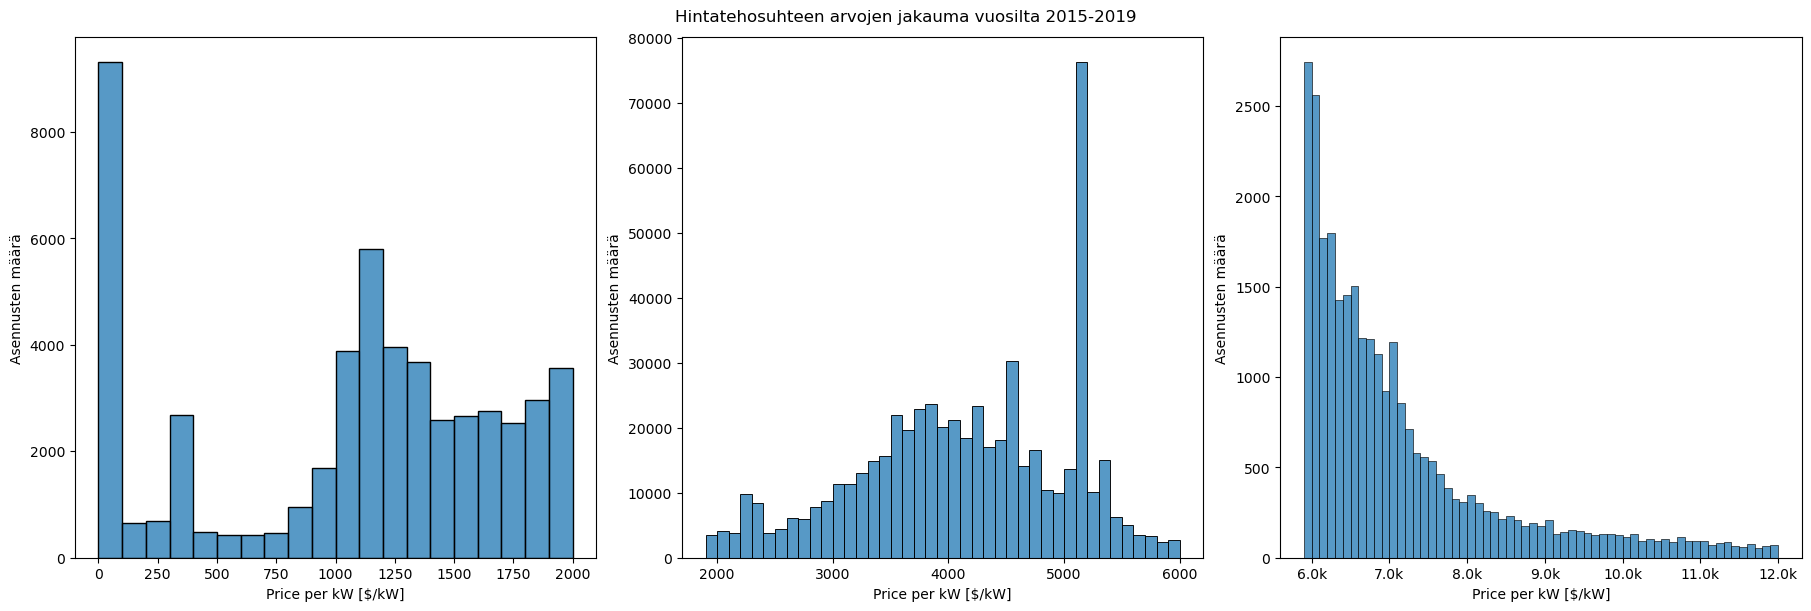

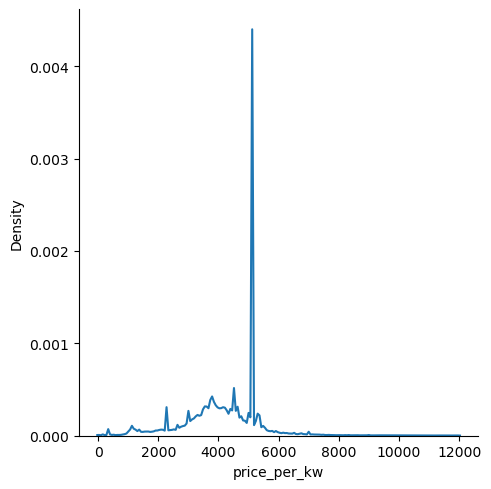

In [6]:
df = df_all.copy()
df = df[(df['year'] > 2014)] # Rajataan tarkasteluväli vuosissa

# Kun binwidth (histplot() -parametri) on vakio, vertailu kuvien välillä on helpompaa
# Sisällytetään myös edellisen kuvan viimeinen palkki 2. ja 3. kuvaan kun rajataan kuvien dataa
binwidth = 100
max_1 = 2000 # Ensimmäisen kuvan raja hintatehosuhteen arvolle
max_2 = 6000
max_3 = 12000

# Datan rajaus eri kuviin
df_1 = df[(df['price_per_kw'] < max_1)]

df_2 = df[(df['price_per_kw'] < max_2)]
df_2 = df_2[(df_2['price_per_kw'] >= (max_1 - binwidth))]

df_3 = df[(df['price_per_kw'] < max_3)]
# Erillinen kde displot
df_kde = df_3.copy()
df_3 = df_3[(df_3['price_per_kw'] >= (max_2 - binwidth))]


# Piirto
fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(18,6))

sns.histplot(data=df_1, x='price_per_kw', ax=axs[0], binwidth=binwidth)
sns.histplot(data=df_2, x='price_per_kw', ax=axs[1], binwidth=binwidth)
sns.histplot(data=df_3, x='price_per_kw', ax=axs[2], binwidth=binwidth)
for i in range(len(axs)):
  axs[i].set_xlabel('Price per kW [$/kW]')
  axs[i].set_ylabel('Asennusten määrä')
axs[0].xaxis.set_major_formatter(no_mult)
axs[1].xaxis.set_major_formatter(no_mult)
axs[2].xaxis.set_major_formatter(kilo)

fig.suptitle('Hintatehosuhteen arvojen jakauma vuosilta 2015-2019')
plt.show()

# df_kde kopioitu df_3
sns.displot(data=df_kde, x='price_per_kw', kind="kde", bw_adjust=.1)
plt.show()

Vertailun vuoksi piirretään vastaavat kuvaajat vuosille 1998-2014.

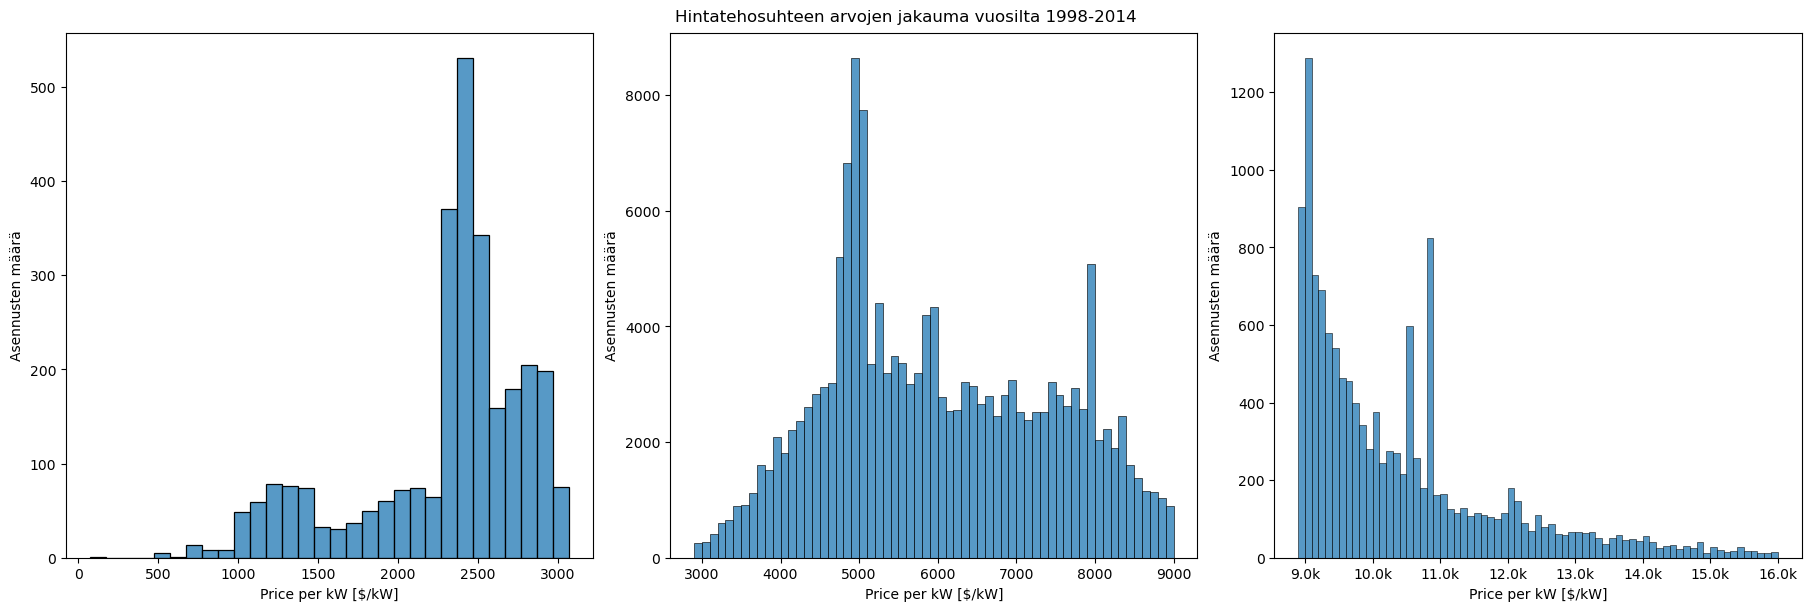

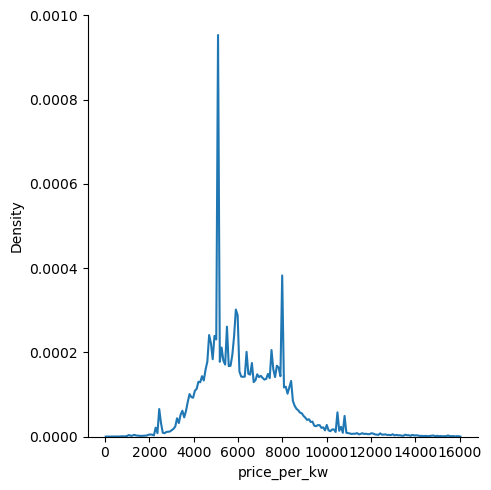

In [7]:
df = df_all.copy()
df = df[(df['year'] <= 2014)] # Rajataan tarkasteluväli vuosissa

# Kun binwidth (histplot() -parametri) on vakio, vertailu kuvien välillä on helpompaa
# Sisällytetään myös edellisen kuvan viimeinen palkki 2. ja 3. kuvaan kun rajataan kuvien dataa
binwidth = 100
max_1 = 3000 # Ensimmäisen kuvan raja hintatehosuhteen arvolle
max_2 = 9000
max_3 = 16000

# Datan rajaus eri kuviin
df_1 = df[(df['price_per_kw'] < max_1)]

df_2 = df[(df['price_per_kw'] < max_2)]
df_2 = df_2[(df_2['price_per_kw'] >= (max_1 - binwidth))]

df_3 = df[(df['price_per_kw'] < max_3)]
# Erillinen kde displot
df_kde = df_3.copy()
df_3 = df_3[(df_3['price_per_kw'] >= (max_2 - binwidth))]

#Piirto
fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(18,6))

sns.histplot(data=df_1, x='price_per_kw', ax=axs[0], binwidth=binwidth)
sns.histplot(data=df_2, x='price_per_kw', ax=axs[1], binwidth=binwidth)
sns.histplot(data=df_3, x='price_per_kw', ax=axs[2], binwidth=binwidth)
for i in range(len(axs)):
  axs[i].set_xlabel('Price per kW [$/kW]')
  axs[i].set_ylabel('Asennusten määrä')
axs[0].xaxis.set_major_formatter(no_mult)
axs[1].xaxis.set_major_formatter(no_mult)
axs[2].xaxis.set_major_formatter(kilo)

fig.suptitle('Hintatehosuhteen arvojen jakauma vuosilta 1998-2014')
plt.show()

sns.displot(data=df_kde, x='price_per_kw', kind="kde", bw_adjust=.08)
plt.show()

## Piirretään kuvaaja ja käytetään enemmän datan suodatusta

Palataan hieman taaksepäin ja otetaan seuraaviin kuvaajiin pohjaksi tämän notebookin ensimmäiset kuvaajat. Suodatetaan sitten hintaan vaikuttavaa dataa pois ja vertaillaan niiden vaikutuksia.

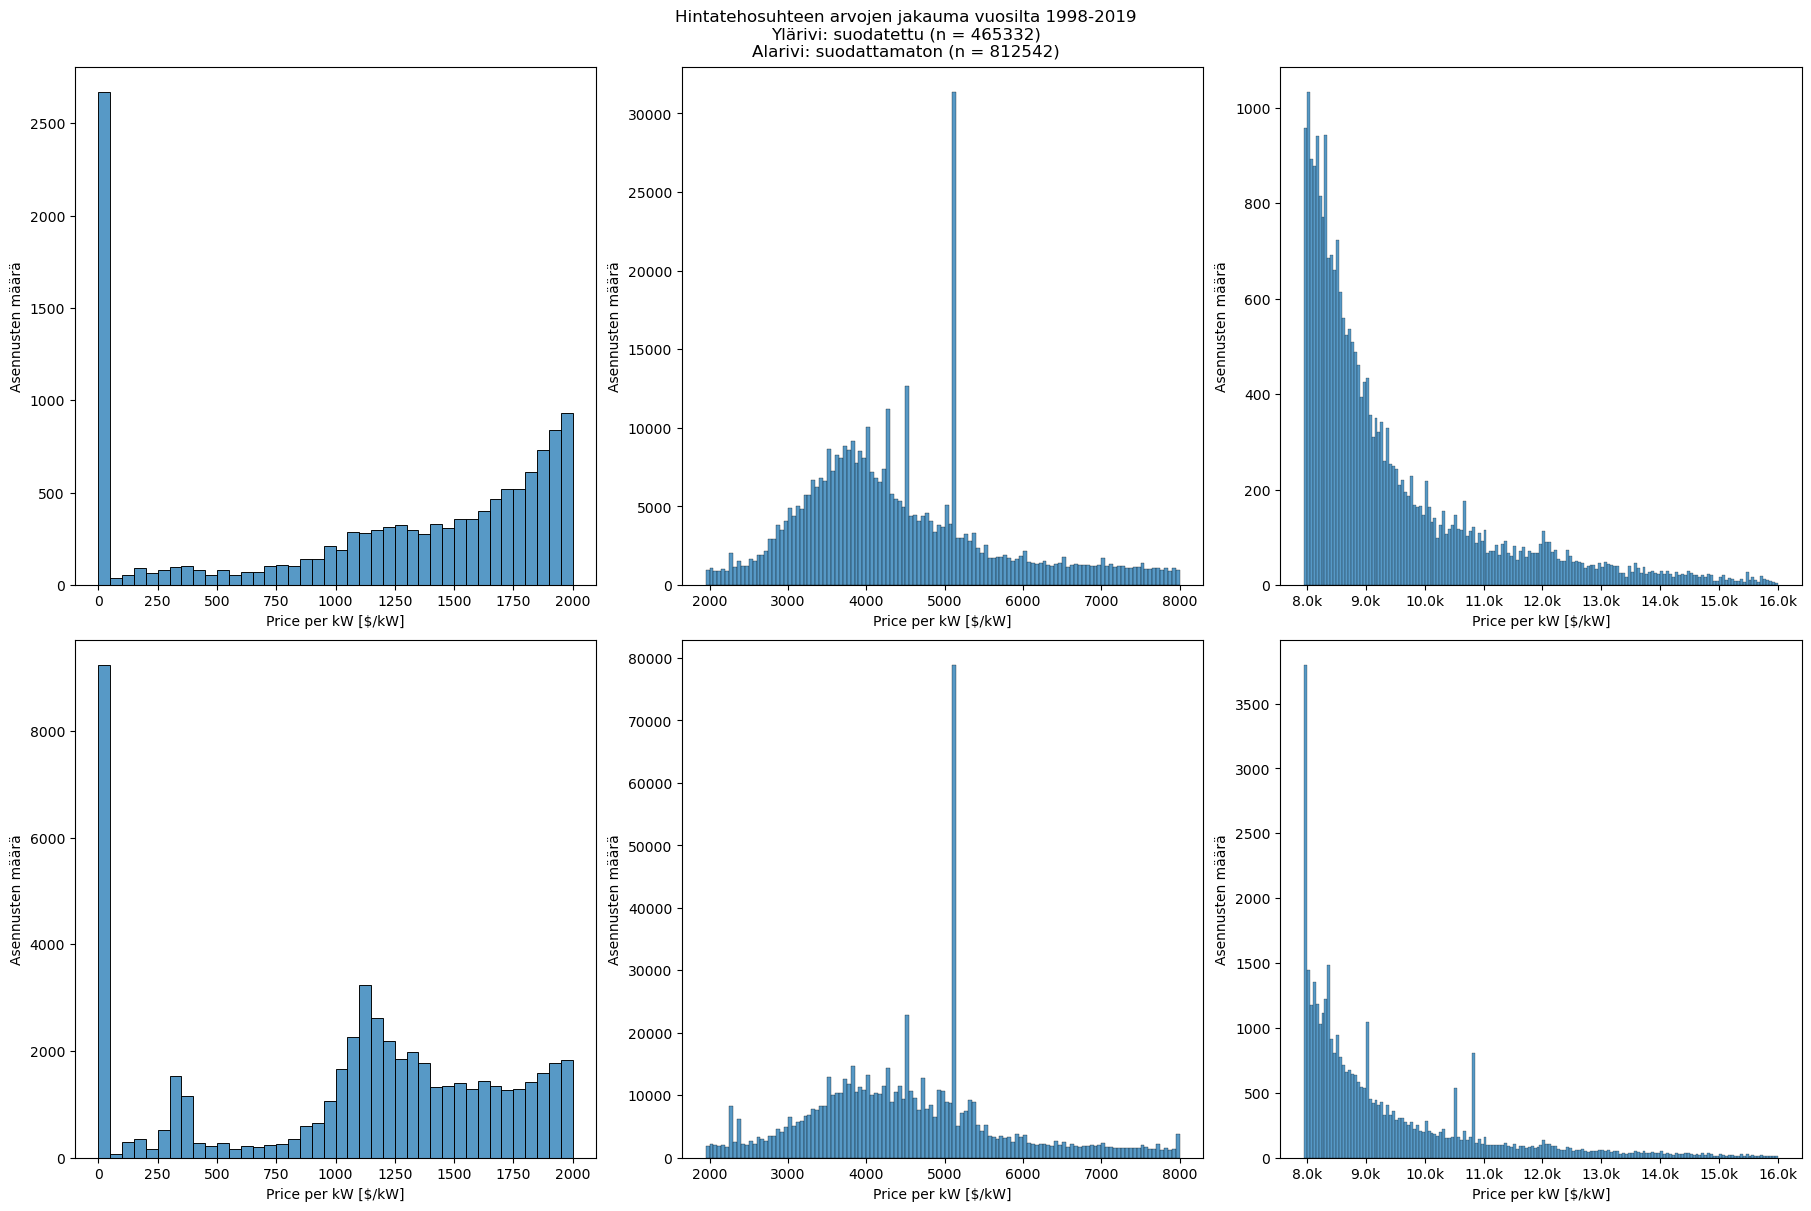

In [8]:
df = df_all.copy()
#df = df[(df['year'] > 2014)] # Rajataan tarkasteluväli vuosissa
df = df[(df['self_installed'] == 0)]
df = df[(df['third_party_owned'] == 0)]

# Kun binwidth (histplot() -parametri) on vakio, vertailu kuvien välillä on helpompaa
# Sisällytetään myös edellisen kuvan viimeinen palkki 2. ja 3. kuvaan kun rajataan kuvien dataa
binwidth = 50
max_1 = 2000 # Ensimmäisen kuvan raja hintatehosuhteen arvolle
max_2 = 8000
max_3 = 16000

# Ylärivi
# Datan rajaus eri kuviin
df_1 = df[(df['price_per_kw'] < max_1)]

df_2 = df[(df['price_per_kw'] < max_2)]
df_2 = df_2[(df_2['price_per_kw'] >= (max_1 - binwidth))]

df_3 = df[(df['price_per_kw'] < max_3)]
count_1 = df_3['price_per_kw'].count()
# Erillinen kde displot
df_kde = df_3.copy()
df_3 = df_3[(df_3['price_per_kw'] >= (max_2 - binwidth))]

# Alarivi
df = df_all.copy()
# Datan rajaus eri kuviin
df_4 = df[(df['price_per_kw'] < max_1)]

df_5 = df[(df['price_per_kw'] < max_2)]
df_5 = df_5[(df_5['price_per_kw'] >= (max_1 - binwidth))]

df_6 = df[(df['price_per_kw'] < max_3)]
count_2 = df_6['price_per_kw'].count()
# Erillinen kde displot
#df_kde = df_3.copy()
df_6 = df_6[(df_6['price_per_kw'] >= (max_2 - binwidth))]

# Piirto
size_mult = 6
fig_rows = 2
fig_cols = 3
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kw', ax=axs[0, 0], binwidth=binwidth)
sns.histplot(data=df_2, x='price_per_kw', ax=axs[0, 1], binwidth=binwidth)
sns.histplot(data=df_3, x='price_per_kw', ax=axs[0, 2], binwidth=binwidth)
sns.histplot(data=df_4, x='price_per_kw', ax=axs[1, 0], binwidth=binwidth)
sns.histplot(data=df_5, x='price_per_kw', ax=axs[1, 1], binwidth=binwidth)
sns.histplot(data=df_6, x='price_per_kw', ax=axs[1, 2], binwidth=binwidth)
for i in range(fig_rows):
  for j in range(fig_cols):
    axs[i, j].set_xlabel('Price per kW [$/kW]')
    axs[i, j].set_ylabel('Asennusten määrä')
  axs[i, 0].xaxis.set_major_formatter(no_mult)
  axs[i, 1].xaxis.set_major_formatter(no_mult)
  axs[i, 2].xaxis.set_major_formatter(kilo)

title = f'''Hintatehosuhteen arvojen jakauma vuosilta 1998-2019
Ylärivi: suodatettu (n = {str(count_1)})
Alarivi: suodattamaton (n = {str(count_2)})'''

fig.suptitle(title)
plt.show()

# df_kde kopioitu df_3 tai df_6
#sns.displot(data=df_kde, x='price_per_kw', kind="kde", bw_adjust=.1)
#plt.show()

Tärkeimpänä havaintona näistä kuvaajista voidaan sanoa, että valituilla suodatuksilla ei voida ratkaista epämääräisten hintojen ongelmaa.

### Muutamia jakauskuvaajia joissa jokin määrätty ehto täyttyy

Piirretään mahdollisten havaintojen toivossa kuvaajat näistäkin:

- self_installed == 1
- third_party_owned == 1
- Systeemissä on akku

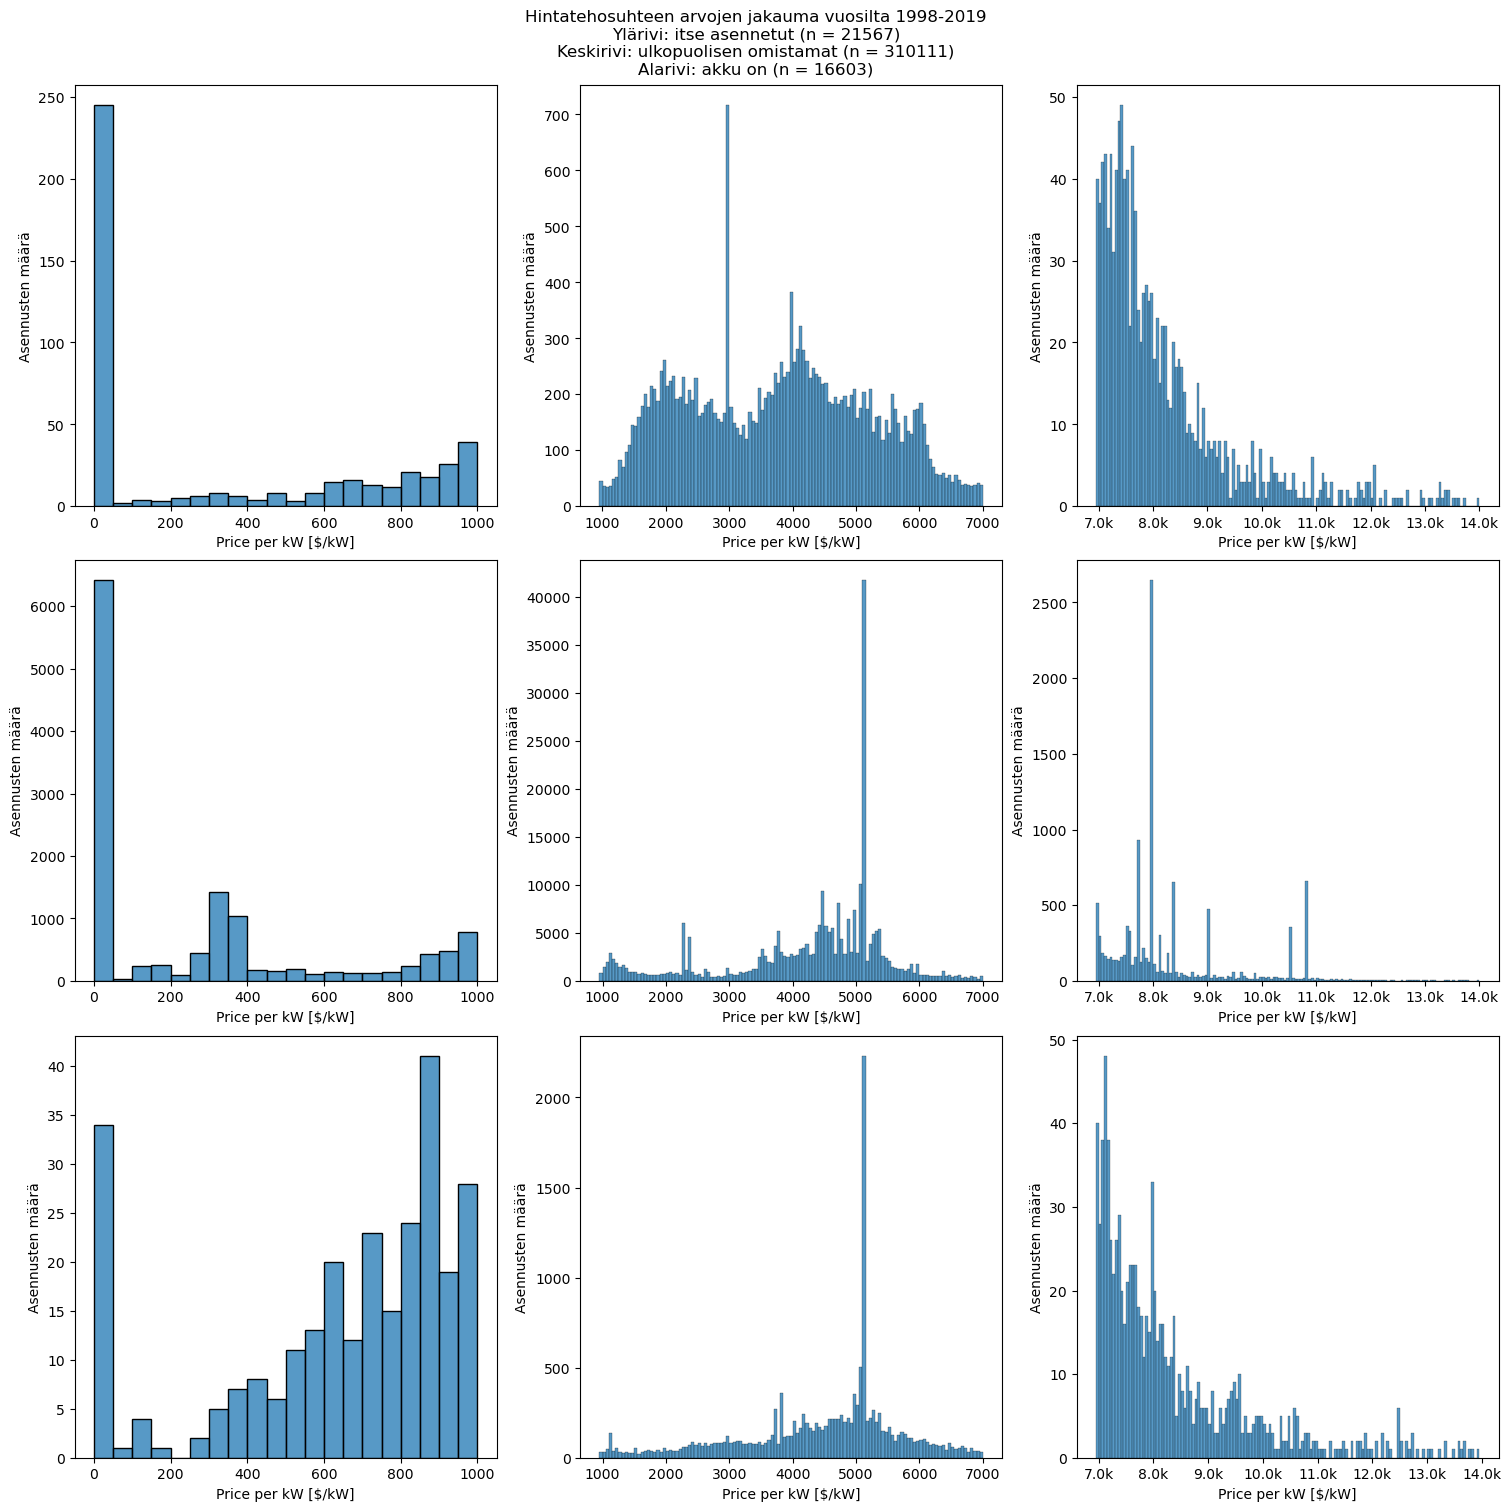

In [9]:
df = df_all.copy()
df = df[(df['self_installed'] == 1)]

# Kun binwidth (histplot() -parametri) on vakio, vertailu kuvien välillä on helpompaa
# Sisällytetään myös edellisen kuvan viimeinen palkki 2. ja 3. kuvaan kun rajataan kuvien dataa
binwidth = 50
max_1 = 1000 # Ensimmäisen kuvan raja hintatehosuhteen arvolle
max_2 = 7000
max_3 = 14000

# Ylärivi
# Datan rajaus eri kuviin
df_1 = df[(df['price_per_kw'] < max_1)]

df_2 = df[(df['price_per_kw'] < max_2)]
df_2 = df_2[(df_2['price_per_kw'] >= (max_1 - binwidth))]

df_3 = df[(df['price_per_kw'] < max_3)]
count_1 = df_3['price_per_kw'].count()
# Erillinen kde displot
df_kde = df_3.copy()
df_3 = df_3[(df_3['price_per_kw'] >= (max_2 - binwidth))]

# Keskirivi
df = df_all.copy()
df = df[(df['third_party_owned'] == 1)]
# Datan rajaus eri kuviin
df_4 = df[(df['price_per_kw'] < max_1)]

df_5 = df[(df['price_per_kw'] < max_2)]
df_5 = df_5[(df_5['price_per_kw'] >= (max_1 - binwidth))]

df_6 = df[(df['price_per_kw'] < max_3)]
count_2 = df_6['price_per_kw'].count()
# Erillinen kde displot
#df_kde = df_3.copy()
df_6 = df_6[(df_6['price_per_kw'] >= (max_2 - binwidth))]

# Alarivi
df = df_all.copy()
df_bat_1 = df[(df['solar_storage_hybrid_inverter_1'] == 1)]
df_bat_2 = df[(df['solar_storage_hybrid_inverter_2'] == 1)]
df_bat_3 = df[(df['solar_storage_hybrid_inverter_3'] == 1)]
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df_bat_4 = df[(df['battery_rated_capacity_kW'] == True)]
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df_bat_5 = df[(df['battery_rated_capacity_kWh'] == True)]

df = pd.concat([df_bat_1, df_bat_2, df_bat_3, df_bat_4, df_bat_5])
df_i = df.index
df['index_col'] = df_i
df.drop_duplicates(subset=['index_col'], inplace=True)

# Datan rajaus eri kuviin
df_7 = df[(df['price_per_kw'] < max_1)]

df_8 = df[(df['price_per_kw'] < max_2)]
df_8 = df_8[(df_8['price_per_kw'] >= (max_1 - binwidth))]

df_9 = df[(df['price_per_kw'] < max_3)]
count_3 = df_9['price_per_kw'].count()
# Erillinen kde displot
#df_kde = df_3.copy()
df_9 = df_9[(df_9['price_per_kw'] >= (max_2 - binwidth))]

# Piirto
size_mult = 5
fig_rows = 3
fig_cols = 3
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kw', ax=axs[0, 0], binwidth=binwidth)
sns.histplot(data=df_2, x='price_per_kw', ax=axs[0, 1], binwidth=binwidth)
sns.histplot(data=df_3, x='price_per_kw', ax=axs[0, 2], binwidth=binwidth)
sns.histplot(data=df_4, x='price_per_kw', ax=axs[1, 0], binwidth=binwidth)
sns.histplot(data=df_5, x='price_per_kw', ax=axs[1, 1], binwidth=binwidth)
sns.histplot(data=df_6, x='price_per_kw', ax=axs[1, 2], binwidth=binwidth)
sns.histplot(data=df_7, x='price_per_kw', ax=axs[2, 0], binwidth=binwidth)
sns.histplot(data=df_8, x='price_per_kw', ax=axs[2, 1], binwidth=binwidth)
sns.histplot(data=df_9, x='price_per_kw', ax=axs[2, 2], binwidth=binwidth)
for i in range(fig_rows):
  for j in range(fig_cols):
    axs[i, j].set_xlabel('Price per kW [$/kW]')
    axs[i, j].set_ylabel('Asennusten määrä')
  axs[i, 0].xaxis.set_major_formatter(no_mult)
  axs[i, 1].xaxis.set_major_formatter(no_mult)
  axs[i, 2].xaxis.set_major_formatter(kilo)

title = f'''Hintatehosuhteen arvojen jakauma vuosilta 1998-2019
Ylärivi: itse asennetut (n = {str(count_1)})
Keskirivi: ulkopuolisen omistamat (n = {str(count_2)})
Alarivi: akku on (n = {str(count_3)})'''

fig.suptitle(title)
plt.show()

# df_kde kopioitu df_3 tai df_6
#sns.displot(data=df_kde, x='price_per_kw', kind="kde", bw_adjust=.1)
#plt.show()

Todetaan, että asennuksen tekeminen itse todella alentaa kuluja. Ulkopuolisen omistamissa voimaloissa on selvä piikki, mikä saattaa viitata tilastoinnin epämääräisyyteen.

## Myös akut suodatettu pois

Piirretään hintajakauma järjestelmille, joista on suodatettu TPO, self_installed ja akut.

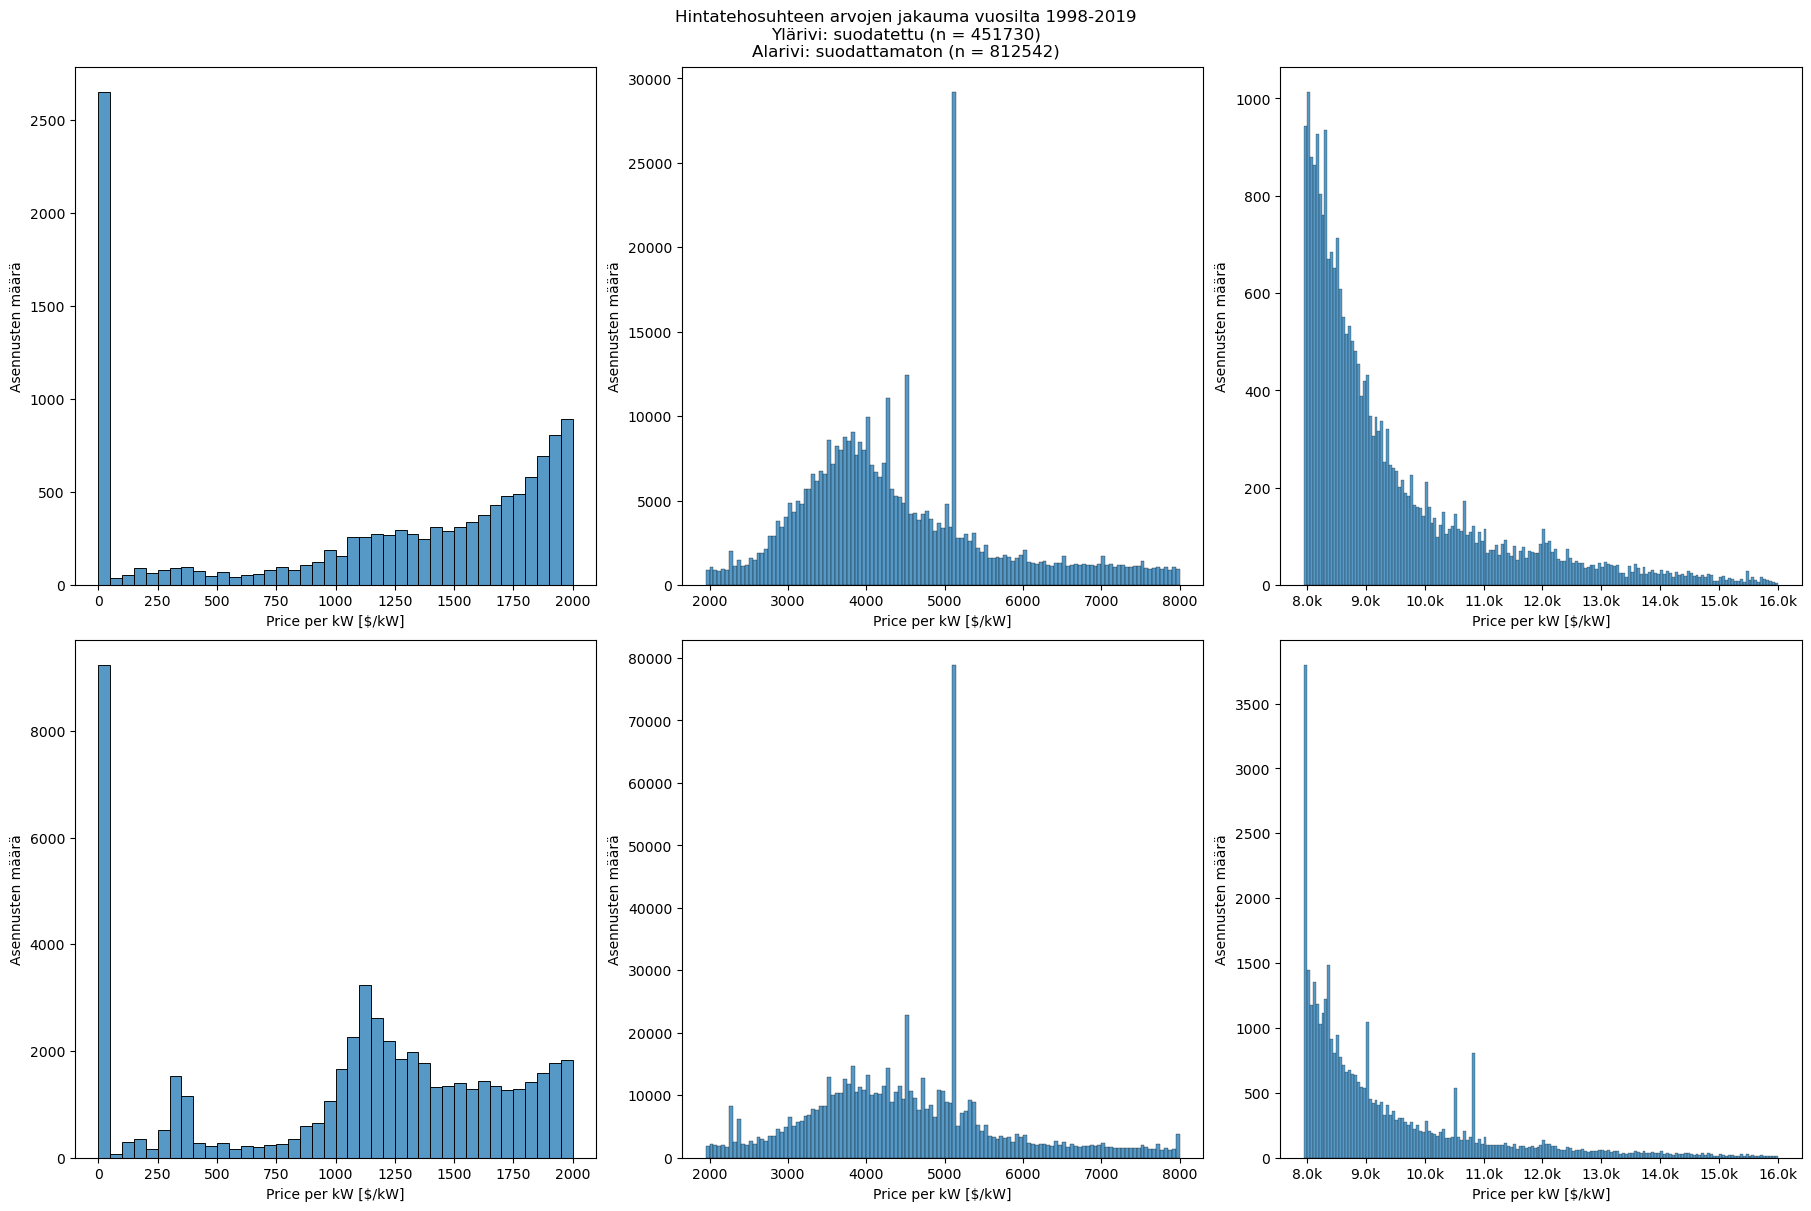

In [10]:
df_ready = df_all.copy()
# Akkusuodatus (kuten vikassa lohkossa)
df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_1'] == 1)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_2'] == 1)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_3'] == 1)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df = df[(df['battery_rated_capacity_kW'] == True)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df = df[(df['battery_rated_capacity_kWh'] == True)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df_ready['total_installed_price'] = df_ready['total_installed_price'].replace(0, np.nan)

# Muut
df_ready = df_ready[(df_ready['self_installed'] == 0)]
df_ready = df_ready[(df_ready['third_party_owned'] == 0)]

df_ready['price_per_kw'] = df_ready['total_installed_price'] / df_ready['system_size_DC']

# Säästetään muokkausta, koska koodi copy-pastettu
df = df_ready

# Kun binwidth (histplot() -parametri) on vakio, vertailu kuvien välillä on helpompaa
# Sisällytetään myös edellisen kuvan viimeinen palkki 2. ja 3. kuvaan kun rajataan kuvien dataa
binwidth = 50
max_1 = 2000 # Ensimmäisen kuvan raja hintatehosuhteen arvolle
max_2 = 8000
max_3 = 16000

# Ylärivi
# Datan rajaus eri kuviin
df_1 = df[(df['price_per_kw'] < max_1)]

df_2 = df[(df['price_per_kw'] < max_2)]
df_2 = df_2[(df_2['price_per_kw'] >= (max_1 - binwidth))]

df_3 = df[(df['price_per_kw'] < max_3)]
count_1 = df_3['price_per_kw'].count()
# Erillinen kde displot
#df_kde = df_3.copy()
df_3 = df_3[(df_3['price_per_kw'] >= (max_2 - binwidth))]

# Alarivi
df = df_all.copy()
# Datan rajaus eri kuviin
df_4 = df[(df['price_per_kw'] < max_1)]

df_5 = df[(df['price_per_kw'] < max_2)]
df_5 = df_5[(df_5['price_per_kw'] >= (max_1 - binwidth))]

df_6 = df[(df['price_per_kw'] < max_3)]
count_2 = df_6['price_per_kw'].count()
# Erillinen kde displot
#df_kde = df_3.copy()
df_6 = df_6[(df_6['price_per_kw'] >= (max_2 - binwidth))]

# Piirto
size_mult = 6
fig_rows = 2
fig_cols = 3
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kw', ax=axs[0, 0], binwidth=binwidth)
sns.histplot(data=df_2, x='price_per_kw', ax=axs[0, 1], binwidth=binwidth)
sns.histplot(data=df_3, x='price_per_kw', ax=axs[0, 2], binwidth=binwidth)
sns.histplot(data=df_4, x='price_per_kw', ax=axs[1, 0], binwidth=binwidth)
sns.histplot(data=df_5, x='price_per_kw', ax=axs[1, 1], binwidth=binwidth)
sns.histplot(data=df_6, x='price_per_kw', ax=axs[1, 2], binwidth=binwidth)
for i in range(fig_rows):
  for j in range(fig_cols):
    axs[i, j].set_xlabel('Price per kW [$/kW]')
    axs[i, j].set_ylabel('Asennusten määrä')
  axs[i, 0].xaxis.set_major_formatter(no_mult)
  axs[i, 1].xaxis.set_major_formatter(no_mult)
  axs[i, 2].xaxis.set_major_formatter(kilo)

title = f'''Hintatehosuhteen arvojen jakauma vuosilta 1998-2019
Ylärivi: suodatettu (n = {str(count_1)})
Alarivi: suodattamaton (n = {str(count_2)})'''

fig.suptitle(title)
plt.show()

# df_kde kopioitu df_3 tai df_6
#sns.displot(data=df_kde, x='price_per_kw', kind="kde", bw_adjust=.1)
#plt.show()

## Luodaan alustava esikäsittelijä

Yritetään kirjoittaa hinnan esikäsittelijä, joka korvaa määrätyt hinnat arvolla `np.nan`.

In [11]:
# df edustaa muokattavaa DataFrame, jota ei tarvita esikäsittelyn jälkeen
df = df_all.copy()
print("Alku:", df['total_installed_price'].count())
# df_ready tulee sisältämään esikäsitellyn version
df_ready = df_all.copy()

# Suodatus nro 1
df = df[(df['price_per_kw'] < 1000)]
print("Poiston määrä, price_per_kw:", df['total_installed_price'].count())
# Laitetaan nolla, koska df.update() ei päivitä nan-arvoja
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

# Suodatus nro 2
df = df_all.copy()
df = df[(df['third_party_owned'] != 0)]
print("Poiston määrä, third_party_owned:", df['total_installed_price'].count())
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

# Suodatus nro 3
df = df_all.copy()
df = df[(df['self_installed'] != 0)]
print("Poiston määrä, self_installed:", df['total_installed_price'].count())
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

# Suodatus nro 4
df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_1'] == 1)]
count_hyb = len(df)
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_2'] == 1)]
count_hyb += len(df)
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_3'] == 1)]
count_hyb += len(df)
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])
print("Poiston määrä, storage_inverter:", count_hyb)

# Suodatus nro 5
df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df = df[(df['battery_rated_capacity_kW'] == True)]
count_bat = len(df)
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df = df[(df['battery_rated_capacity_kWh'] == True)]
count_bat += len(df)
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])
print("Poiston määrä, battery:", count_bat)

# Lopuksi poistetaan nollat, korvaus np.nan
df_ready['total_installed_price'] = df_ready['total_installed_price'].replace(0, np.nan)
print("nan korvauksen jälkeen:", df_ready['total_installed_price'].count())
print("Käsitellyn df:n rivien määrä:" ,df_ready['installation_date'].count())

# Tämä tulisi sisällyttää vain, jos sarake valitaan mukaan
df_ready['price_per_kw'] = df_ready['total_installed_price'] / df_ready['system_size_DC']


df_ready.groupby(['self_installed', 'third_party_owned']).agg({
  'total_installed_price': ['count', 'min', 'median', 'mean', 'max'],
  'system_size_DC':        ['count', 'min', 'median', 'mean', 'max'],
  'price_per_kw':          ['count', 'min', 'median', 'mean', 'max']})

Alku: 814364
Poiston määrä, price_per_kw: 17772
Poiston määrä, third_party_owned: 317878
Poiston määrä, self_installed: 41379
Poiston määrä, storage_inverter: 3487
Poiston määrä, battery: 22461
nan korvauksen jälkeen: 449000
Käsitellyn df:n rivien määrä: 1000000


total_installed_price                  \
                                                 count    min   median   
self_installed third_party_owned                                         
0.0            0.0                              449000  900.0  25000.0   
               1.0                                   0    NaN      NaN   
1.0            0.0                                   0    NaN      NaN   
               1.0                                   0    NaN      NaN   

                                                          system_size_DC  \
                                         mean         max          count   
self_installed third_party_owned                                           
0.0            0.0                40830.98263  20000000.0         538413   
               1.0                        NaN         NaN         336203   
1.0            0.0                        NaN         NaN          18188   
               1.0                        NaN         NaN           4361   

                                                                          \
                                       min median       mean         max   
self_installed third_party_owned                                           
0.0            0.0                0.005500  5.720  10.268770  13305.6100   
               1.0                0.005500  5.355   8.412134   7586.5625   
1.0            0.0                0.019837  5.060   7.273876   1176.0000   
               1.0                0.064900  3.850   6.358810   2097.2280   

                                 price_per_kw                               \
                                        count     min  median         mean   
self_installed third_party_owned                                             
0.0            0.0                     448971  1000.0  4250.0  4717.659286   
               1.0                          0     NaN     NaN          NaN   
1.0            0.0                          0     NaN     NaN          NaN   
               1.0                          0     NaN     NaN          NaN   

                                                 
                                            max  
self_installed third_party_owned                 
0.0            0.0                823842.151675  
               1.0                          NaN  
1.0            0.0                          NaN  
               1.0                          NaN

## Yksinkertaisempi esikäsittelylohko

In [12]:
df = df_all.copy()
df_ready = df_all.copy()
df['price_per_kw'] = df['total_installed_price'] / df['system_size_DC']
df = df[(df['price_per_kw'] < 1000)]
df['total_installed_price'] = 0
df_ready.update(df)

df = df_all.copy()
df = df[(df['third_party_owned'] != 0)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['self_installed'] != 0)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_1'] == 1)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_2'] == 1)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df = df[(df['solar_storage_hybrid_inverter_3'] == 1)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df = df[(df['battery_rated_capacity_kW'] == True)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df = df_all.copy()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df = df[(df['battery_rated_capacity_kWh'] == True)]
df['total_installed_price'] = 0
df_ready.update(df['total_installed_price'])

df_ready['total_installed_price'] = df_ready['total_installed_price'].replace(0, np.nan)

# Tarkastuksessa tulostaa arvot 
# 449000
# 900.0
# 25000.0
# 40830.98262973724
# 20000000.0
# jos karsinnan ehdot ovat [
# 'price_per_kw' < 1000 && 
# 'third_party_owned' != 0 && 
# 'self_installed' != 0 && 
# 'solar_storage_hybrid_inverter' == 1 && 
# 'battery_rated_capacity_kW' == True && 
# 'battery_rated_capacity_kWh' == True]
print(df_ready['total_installed_price'].count())
print(df_ready['total_installed_price'].min())
print(df_ready['total_installed_price'].median())
print(df_ready['total_installed_price'].mean())
print(df_ready['total_installed_price'].max())

449000
900.0
25000.0
40830.98262973724
20000000.0
